In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

import re
import string
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

import spacy
import spacy.cli

from spacy.lang.en.stop_words import STOP_WORDS

import nltk
nltk.download('punkt') 
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud
from collections import  Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
file = 'data_to_NLP.csv'
df = pd.read_csv(file, index_col=0)
df.head()

,articleID,publication_date,text,len_text,label
0,3393,1976-03-01,Treatment of tardive dyskinesia.,4,0
1,3393,1976-03-01,An effective schema for the treatment of tardi...,25,0
2,3393,1976-03-01,The former is thought to be related to central...,24,0
3,3393,1976-03-01,The pathogenesis of tardive dyskinesia is dist...,17,0
4,18795,1977-06-01,Asthma and urticaria during disodium cromoglyc...,10,0


# Preprocessing before word embedding



In [ ]:
def remove_features(data_str):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0

    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    # remove unwanted space, *.split() will automatically split on
    # whitespace and discard duplicates, the " ".join() joins the
    # resulting list into one string.
    
    return " ".join(cleaned_str.split())

In [ ]:
%%time
df['cleaned_text'] = df['text'].apply(lambda x : remove_features(x))

CPU times: user 522 ms, sys: 1.86 ms, total: 524 ms
Wall time: 531 ms


In [ ]:
df.head()

,articleID,publication_date,text,len_text,label,cleaned_text
0,3393,1976-03-01,Treatment of tardive dyskinesia.,4,0,treatment of tardive dyskinesia
1,3393,1976-03-01,An effective schema for the treatment of tardi...,25,0,an effective schema for the treatment of tardi...
2,3393,1976-03-01,The former is thought to be related to central...,24,0,the former is thought to be related to central...
3,3393,1976-03-01,The pathogenesis of tardive dyskinesia is dist...,17,0,the pathogenesis of tardive dyskinesia is dist...
4,18795,1977-06-01,Asthma and urticaria during disodium cromoglyc...,10,0,asthma and urticaria during disodium cromoglyc...


# Spacy + WordCloud

In [ ]:
spacy.cli.download('en_core_web_lg')

nlp = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
def word_cloud(text):
  corpus = ''.join(text.to_list())
  
  nlp.max_length = len(corpus)
  doc = nlp(corpus)

  wd = WordCloud(stopwords=STOP_WORDS)
  cloud = wd.generate(doc.text)
  plt.imshow(cloud)
  plt.show

word cloud of possitive cases


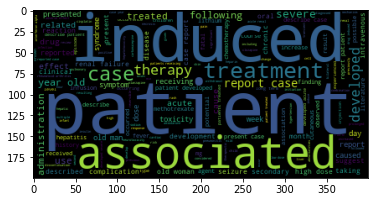

In [ ]:
print('word cloud of possitive cases')
word_cloud(df[df['label']==1]['cleaned_text'])

word cloud of negative cases


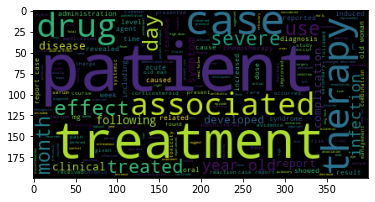

In [ ]:
print('word cloud of negative cases')
word_cloud(df[df['label']==0]['cleaned_text'])

 ## DEEP LEARNING : NLP 
 * Tokenize
 * Model NLP with LSTM

### Tokenize

In [ ]:

# Création d'une instance Tokenizer
tokenizer = tfds.features.text.Tokenizer()

# Nous allons tokenizer chacun des mots en elevant les doublons via l'utilisation de set()
vocabulary_set = set()
for text_tensor, _ in tf_data:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size


16440

In [ ]:
# Création d'un nombre pour chacun des tokens que nous avons créés au dessus
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [ ]:

# Encodons maintenant tous les éléments d'un dataset
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

# Utilisation du fonction py_function pour encoder tout le dataset 
def encode_map_fn(text, label):
  return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

all_encoded_data = tf_data.map(encode_map_fn)


In [ ]:
# Train Test Split
TRAIN_SIZE = int(0.6 * len(df))
VAL_TEST_SIZE = int(0.2 * len(df))
BATCH_SIZE = 16

tf_train = all_encoded_data.take(TRAIN_SIZE).shuffle(TRAIN_SIZE)
tf_test = all_encoded_data.skip(TRAIN_SIZE)
tf_val = tf_test.skip(VAL_TEST_SIZE)
tf_test = tf_test.take(VAL_TEST_SIZE)

tf_train = tf_train.padded_batch(BATCH_SIZE, padded_shapes=([-1], []))
tf_val = tf_val.padded_batch(BATCH_SIZE, padded_shapes=([-1], []))
tf_test = tf_test.padded_batch(BATCH_SIZE, padded_shapes=([-1], []))

### Model

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]


# loss function
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=6000,
    decay_rate=0.90,
    staircase=True)


def make_model(metrics = METRICS, output_bias=None):
  model = tf.keras.Sequential([
                               # Couche d'Input Word Embedding           
                              tf.keras.layers.Embedding(vocab_size+1, 16),

                              # Couche LSTM Bidirectionnelle
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False)),
                  
                              # Couche Dense classique 
                              tf.keras.layers.Dense(16, activation='relu'),
                              tf.keras.layers.Dense(8, activation='relu'),

                              # Couche de sortie avec fonction d'activation sigmoid
                              tf.keras.layers.Dense(1, activation='sigmoid')])
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr_schedule),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics, )

  return model

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          263056    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 267,953
Trainable params: 267,953
Non-trainable params: 0
_________________________________________________________________


#### Define class_weight for each class

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df['label']),
                                                 df['label'])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6256591562799616, 1: 2.4895088221268478}

In [ ]:
#Early Stopping
callbacks = [EarlyStopping(monitor='loss', patience=3, verbose=1)]

history = model.fit(tf_train, epochs=100, validation_data=tf_val,
                    callbacks=callbacks, class_weight=class_weights)

Epoch 1/100
784/784 [==============================] - 18s 22ms/step - loss: 0.6865 - tp: 1121.0000 - fp: 2452.0000 - tn: 7567.0000 - fn: 1389.0000 - accuracy: 0.6934 - precision: 0.3137 - recall: 0.4466 - auc: 0.6545 - val_loss: 0.6400 - val_tp: 490.0000 - val_fp: 351.0000 - val_tn: 2949.0000 - val_fn: 387.0000 - val_accuracy: 0.8233 - val_precision: 0.5826 - val_recall: 0.5587 - val_auc: 0.8314
Epoch 2/100
784/784 [==============================] - 16s 21ms/step - loss: 0.5472 - tp: 1846.0000 - fp: 2059.0000 - tn: 7948.0000 - fn: 676.0000 - accuracy: 0.7817 - precision: 0.4727 - recall: 0.7320 - auc: 0.8282 - val_loss: 0.4712 - val_tp: 687.0000 - val_fp: 634.0000 - val_tn: 2710.0000 - val_fn: 146.0000 - val_accuracy: 0.8133 - val_precision: 0.5201 - val_recall: 0.8247 - val_auc: 0.8861
Epoch 3/100
784/784 [==============================] - 17s 21ms/step - loss: 0.4188 - tp: 2026.0000 - fp: 1561.0000 - tn: 8500.0000 - fn: 442.0000 - accuracy: 0.8401 - precision: 0.5648 - recall: 0.820

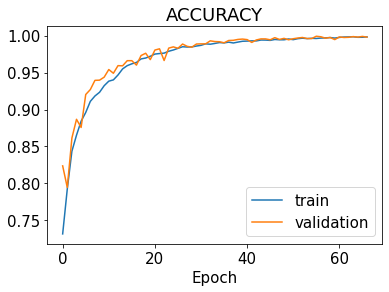

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.title('ACCURACY')
plt.xlabel('Epoch')
plt.rc('font', size=15)
plt.show()

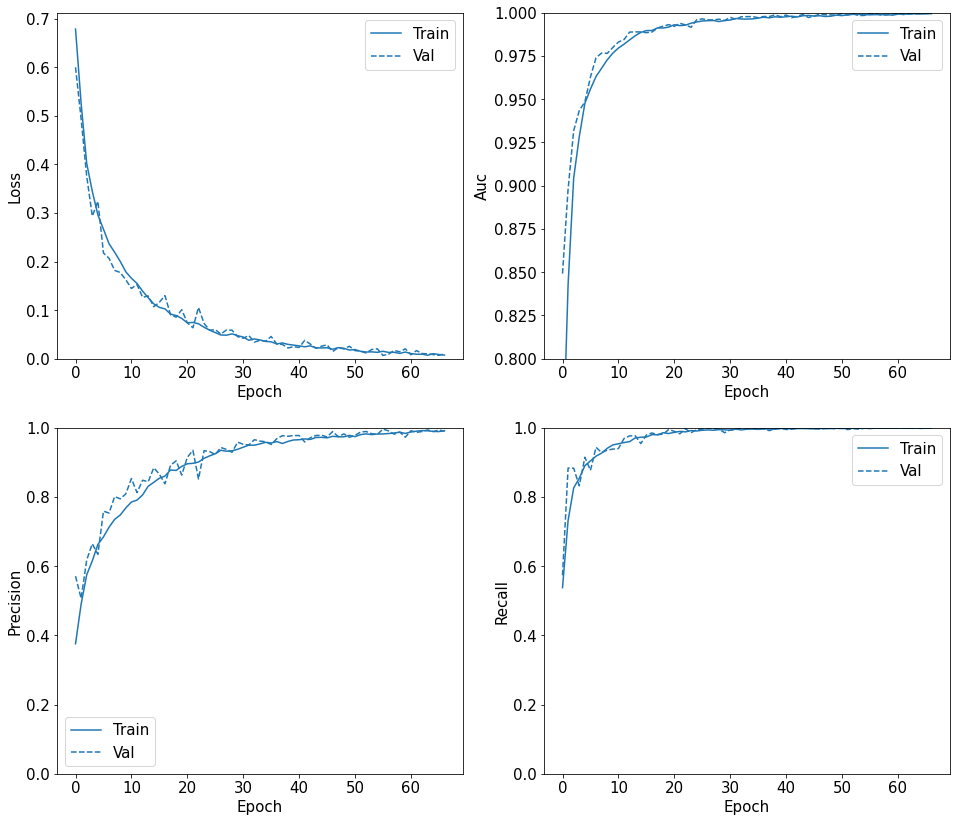

In [ ]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

  plt.figure(figsize=[16, 14])
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.rc('font', size=15)

plot_metrics(history)

### Test on TEST SET

In [ ]:
test_evaluation = model.evaluate(tf_test)
test_evaluation

261/261 [==============================] - 3s 10ms/step - loss: 0.0328 - tp: 796.0000 - fp: 26.0000 - tn: 3351.0000 - fn: 3.0000 - accuracy: 0.9931 - precision: 0.9684 - recall: 0.9962 - auc: 0.9970


[0.03284458816051483,
 796.0,
 26.0,
 3351.0,
 3.0,
 0.9930555820465088,
 0.9683698415756226,
 0.9962453246116638,
 0.9969697594642639]

In [ ]:
tp = test_evaluation[1]
fp = test_evaluation[2]
tn = test_evaluation[3]
fn = test_evaluation[4]

cm = [[tn, fn], [fp, tp]]
display(pd.DataFrame(cm))

,0,1
0,3351.0,3.0
1,26.0,796.0


Text(0.5, 28.0, 'Predicted label')

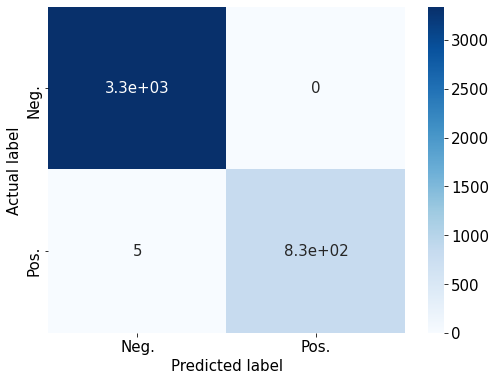

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xticklabels(['Neg.', 'Pos.'])
ax.set_yticklabels(['Neg.', 'Pos.'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Save model

In [ ]:
#saving encoder

import pickle

# saving
with open('encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.save('NLP_classification_sentence')

INFO:tensorflow:Assets written to: NLP_classification_sentence/assets


In [ ]:
#copy saved model to drive
!cp encoder.pickle '/content/drive/My Drive/ML_projects/NLP_DRUG/'
!cp -r NLP_classification_sentence '/content/drive/My Drive/ML_projects/NLP_DRUG/'

#Predict on new text

In [ ]:
import pickle
with open('encoder.pickle', 'rb') as handle:
    encoder = pickle.load(handle)

In [ ]:
def sample_predict(sample_pred_text):
  
  encoded_sample_pred_text = encoder.encode(sample_pred_text)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)

  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return predictions[0]

In [ ]:
# predict on a sample text without padding.

sample_pred_text = df.loc[20801, 'cleaned_text']
print(sample_pred_text)
predictions = sample_predict(sample_pred_text)
print(predictions)

if predictions > 0.5:
  print('ADR found')
else:
  print("No ADR found")

[0.9995117]
ADR found
